In [39]:
!ls ResultsJson/LAST_smoothing_smoothing

10000.json  22098.json	34210.json  46308.json	58392.json  7045.json
10001.json  22099.json	34211.json  46309.json	58393.json  70460.json
10002.json  2209.json	34212.json  4630.json	58394.json  70461.json
10003.json  22100.json	34213.json  46310.json	58395.json  70462.json
10004.json  22101.json	34214.json  46311.json	58396.json  70463.json
10005.json  22102.json	34215.json  46312.json	58397.json  70465.json
10006.json  22103.json	34216.json  46313.json	58398.json  70466.json
10007.json  22104.json	34217.json  46314.json	58399.json  70467.json
10008.json  22105.json	34218.json  46315.json	5839.json   70468.json
10009.json  22106.json	34219.json  46316.json	583.json    70469.json
1000.json   22107.json	3421.json   46317.json	58400.json  7046.json
10010.json  22108.json	34220.json  46318.json	58401.json  70470.json
10011.json  22109.json	34222.json  46319.json	58402.json  70471.json
10012.json  2210.json	34223.json  4631.json	58403.json  70472.json
10013.json  22110.json	34224.json  46320

limit_output extension: Maximum message size of 20000 exceeded with 63833 characters

In [2]:
with open("ResultsJson/LAST_smoothing_smoothing/1000.json") as json_data:
    data= json.load(json_data)
data.keys()

dict_keys(['preds', 'waypoint_preds', 'rotation', 'translation', 'csv_file', 'city', 'agent_labels', 'agent_features', 'social_features', 'social_label_features', 'att_weights'])

In [5]:
import numpy as np

print(np.array(data["att_weights"]).shape)
print(np.array(data["agent_labels"]).shape)
print(np.array(data["att_weights"]).shape)
# print(np.array(data["att_weights"]).shape)
# print(np.array(data["att_weights"]).shape)
# print(np.array(data["att_weights"]).shape)

(4, 26, 26)
(30, 2)
(4, 26, 26)


In [6]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import json
import os
from argoverse.map_representation.map_api import ArgoverseMap

am = ArgoverseMap() # 여기는 지도를 그리기 위한 API로 https://github.com/argoai/argoverse-api 를 참조하여 api를 설치하신 후에 사용 가능합니다.


In [67]:
import torch
import math
from shapely.geometry import LineString

def denormalization(arr, angle, translation_x, translation_y): # 테스트 결과근 normalize되서 나오므로 이를 다시 denormalization 시키는 코드

    theta = (angle)/180*math.pi
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    #rotate
    arr = np.array([R.dot(arr[...,:2][i].reshape((2,1))).flatten() for i in range(len(arr[...,:2]))])

    #translate
    arr[...,0] += translation_x
    arr[...,1] += translation_y
#     arr[...,0] += (AGENT[19,0] - AGENT[0,0])
#     arr[...,1] += (AGENT[19,1] - AGENT[0,1])
    return arr


def draw(AGENT, AVs, json_dict,graph_weight = None, head_num = 0, figsize = (8,8), Normalize = False, title = None, 
         draw_future = True, mode = "av2agent"):
    
    
    assert mode == "av2agent" or mode == "agent2av", "mode must be 'agent2av' or 'av2agent'"
    plt.ion()
    plt.figure(figsize=figsize)
    if title != None:
        plt.title(title)
    
    x_mean = np.array(json_dict['preds'])[0,:,0,0].mean()
    y_mean = np.array(json_dict['preds'])[0,:,0,1].mean()

    angle_ans = -json_dict['rotation']

    xmin, xmax, ymin,ymax = [9999], [-9999], [9999], [-9999]

    json_dict['preds'] = [[np.array(json_dict['preds'])[0][i] - json_dict['preds'][0][i][:1] for i in range(len(json_dict['preds'][0]))]]    # calculate x's mean and y's mean in predict
#     graph_weight = graph_weight[head_num]/ max(np.max(graph_weight[head_num]), 0.00001)
    graph_weight = graph_weight[head_num]
    if draw_future:
        for p in json_dict['preds'][0]:
            p = denormalization(np.array(p), angle_ans, -json_dict['translation'][0], -json_dict['translation'][1])
            p += AGENT[-1] - AGENT[0]
            plt.plot(p[...,0], p[...,1], linestyle='dashed', alpha = 0.5, zorder = -1)
            plt.scatter(p[...,0][-1], p[...,1][-1], linewidth=2, alpha = 0.5, zorder = -1)
            xmin, xmax = min(np.append(xmin, p[...,0])), max(np.append(xmax, p[...,0]))
            ymin, ymax = min(np.append(ymin, p[...,1])), max(np.append(ymax, p[...,1]))
        

    plt.plot(AGENT[...,0],AGENT[...,1], color='blue')
    plt.scatter(AGENT[...,0][-1],AGENT[...,1][-1], color='blue',linewidth=8)
    plt.scatter(AGENT[...,0][19],AGENT[...,1][19], color='blue')

#     print(graph_weight[3][0])
#     graph_weight[3][0] = graph_weight[3][0] / max(max(graph_weight[3][0]), 0.00001)
    

    for i, AV in enumerate(AVs):
        
        if AGENT[:,0][0] != AVs[i][:,0][0]: # 간혹 AV의 trajectory가 0으로 초기화 되어 있는 경우가 있는데 이 경우 AGENT의 초기값과 같아져 발생하는 오류때문에 넣어줌
            plt.plot(AV[...,0],AV[...,1], color='black')
            plt.scatter(AV[...,0][-1],AV[...,1][-1], color='black')
            if mode == "av2agent":
                plt.scatter(AV[...,0][-1],AV[...,1][-1], color='red', linewidth = 8, alpha = graph_weight[0][i+1])
            elif mode == "agent2av":
                plt.scatter(AV[...,0][-1],AV[...,1][-1], color='red', linewidth = 8, alpha = graph_weight[0][i+1])
            
            
            xmin = min(np.append(np.append(AGENT[...,0], AV[...,0]),xmin))
            xmax = max(np.append(np.append(AGENT[...,0], AV[...,0]),xmax))
            ymin = min(np.append(np.append(AGENT[...,1], AV[...,1]),ymin))
            ymax = max(np.append(np.append(AGENT[...,1], AV[...,1]),ymax))

    #draw map
#     print(graph_weight[head_num])
    local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
#     print(xmin, xmax, ymin, ymax)
    for l in local_lane_polygons:
        plt.plot(l[...,0],l[...,1], linewidth='0.5', color='gray')

    plt.savefig(f'results_WIMP_attentinon/{json_dict["csv_file"].split(".")[0]}_{head_num}.png')
#     plt.show()
    plt.close()


  0%|          | 0/78143 [00:00<?, ?it/s]

KeyboardInterrupt: 

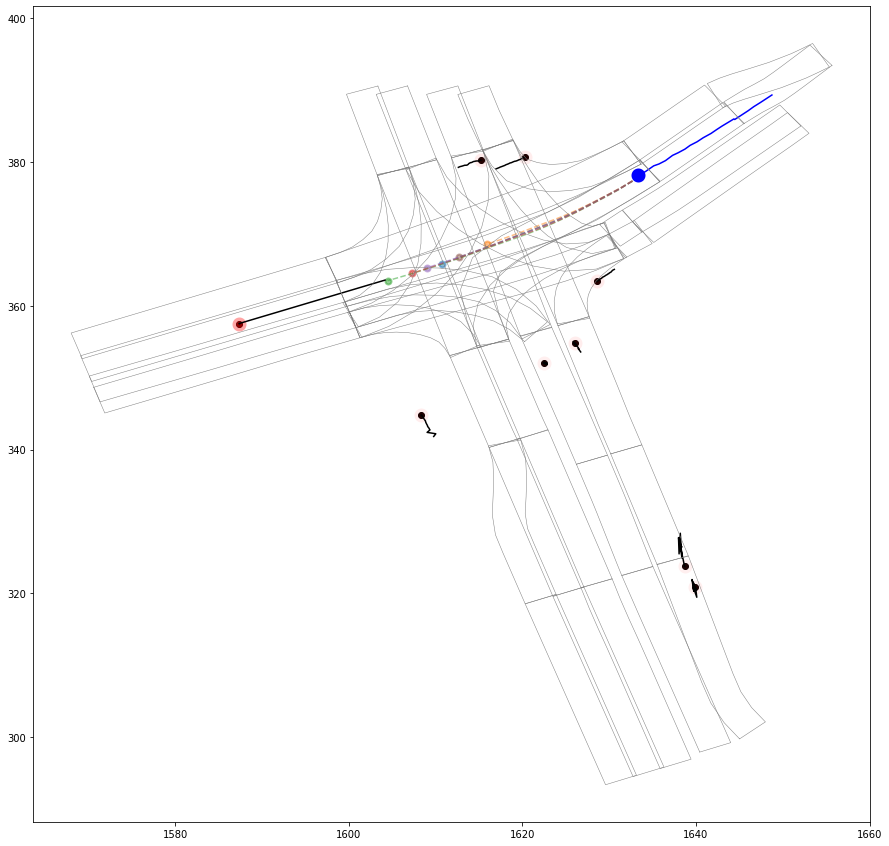

In [69]:
from tqdm.notebook import tqdm
import pickle 

root_dir = "ResultsJson/LAST_smoothing_smoothing/"  # Test결과 파일이 있는 위치
raw_data_dir = "./../WIMP/data/argoverse_processed_simple/test/" #argoverse rawdata(csv 파일)이 저장되어 있는 위치



file_list = sorted(os.listdir(raw_data_dir), key=lambda a : str(a.split('.')[0]))

for index in tqdm(range(len(file_list))): # 전체를 다 그리기는 힘드므로 일부만 시각화

    json_dict = {}

    with open(raw_data_dir + file_list[index], 'rb') as json_data:
        pickle_dict = pickle.load(json_data)

    with open(root_dir + file_list[index].split(".")[0] + ".json", 'r') as json_data:
        json_dict = json.load(json_data)
        

        
    rt = -json_dict["rotation"]
    tx = -json_dict["translation"][0]
    ty = -json_dict["translation"][1]

    social_features = [d["XY_FEATURES"] for d in pickle_dict["SOCIAL"]]
    
    AVs = np.array([denormalization(np.array(json_dict["social_features"][i]), rt, tx, ty) for i in range(len(json_dict["social_features"]))])
    AGENT = denormalization(np.array(pickle_dict["AGENT"]["XY_FEATURES"]), rt, tx, ty)
    graph_weight = np.array(json_dict["att_weights"])
    
    
    city_name = json_dict["city"]
#     AV = np.array(AV)
#     AGENT = np.array(AGENT)
    
    for i in range(1):
        # av2agent # agent 에게 영향을 주는 것
        draw(AGENT, AVs, json_dict, figsize=(15,15), Normalize = True, graph_weight=graph_weight, head_num = 3, mode = "av2agent") 


In [51]:
np.max(graph_weigt[0])

0.6540898680686951